In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

from google.colab import drive
import os
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change directory to load the data -- change back after it has been loaded!!!
import os
os.chdir("/content/drive/MyDrive/2021_Zhebin_Math_Thesis/")
!pwd
!ls

# Use a number of custom code files to make it easier to manipulate the data.
# This is the easiest way to make the modules accessible:
import sys
sys.path.append('./utils')

/content/drive/MyDrive/2021_Zhebin_Math_Thesis
 Aone_256x256px.pkl		     Research_Journel.docx
 Bfour_256x256px.pkl		     TestData40X_CTC_withoutseg_RGB
 cancer_256x256px.pkl		     Test_Data_PNG
 CNN				    'TF_CNN_BinImages .ipynb'
'Homecoming Poster Session.gsheet'   TrainData40X_CTC_withoutseg_RGB
 None_256x256px.pkl		     Train_Data_.DAT
 Paper_Reference		     Train_Data_.PNG
 Pone_256x256px.pkl		     utils


### Label the Image with their folder name


In [ ]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

# New Section

In [ ]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1}) cancer images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'TIF', 'tif'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [ ]:
# modify to fit your system
data_path = '/content/drive/MyDrive/2021_Zhebin_Math_Thesis/TrainData40X_CTC_withoutseg_RGB'

os.listdir(data_path)

['One', 'Aone', 'Bfour', 'Three']

### Split dataset in original way

In [ ]:
base_name = 'cancer'
width = 256
include = {'One', 'Aone', 'Bfour', 'Three'}

resize_all(src=data_path, pklname=base_name, width=width, include=include)


One
Aone
Bfour
Three


In [ ]:
from collections import Counter

data = joblib.load(f'{base_name}_{width}x{width}px.pkl')

print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  1157
keys:  ['description', 'label', 'filename', 'data']
description:  resized (256x256) cancer images in rgb
image shape:  (256, 256, 3)
labels: ['Aone' 'Bfour' 'One' 'Three']


Counter({'Aone': 114, 'Bfour': 741, 'One': 172, 'Three': 130})

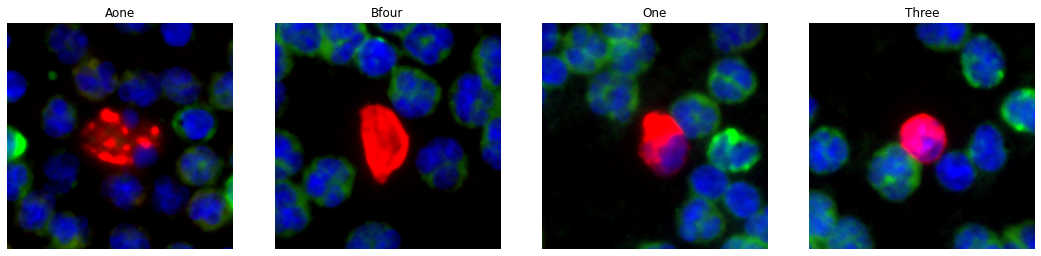

In [ ]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])

# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [ ]:
X = np.array(data['data'])
y = np.array(data['label'])

In [ ]:
from sklearn.model_selection import train_test_split
 

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.1, 
    shuffle=True,
    random_state=42,
)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1041, 256, 256, 3)
(1041,)
(116, 256, 256, 3)


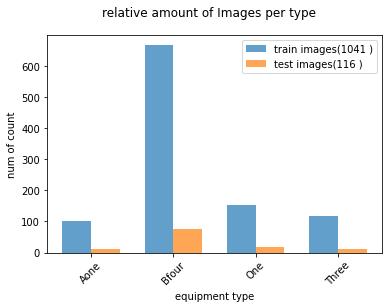

In [ ]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = counts[sorted_index]
        #counts = 100*counts[sorted_index]/len(y)
        ylabel_text = 'num of count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of Images per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train images({0} )'.format(len(y_train)), 
    'test images({0} )'.format(len(y_test))
]);

### Build CNN model in TensorFlow


In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=(256,256,3)))
  model.add(tf.keras.layers.Conv2D(16, (5, 5), padding='same', activation=LeakyReLU(alpha=0.1))) # activation = 'relu'
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation=LeakyReLU(alpha=0.1)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation=LeakyReLU(alpha=0.1)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=(256,256,3)))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation=LeakyReLU(alpha=0.1)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=(256,256,3)))
  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation=LeakyReLU(alpha=0.1)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=(256,256,3)))
  model.add(tf.keras.layers.Conv2D(512, (5, 5), padding='same', activation=LeakyReLU(alpha=0.1)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(2048))
  model.add(LeakyReLU(alpha=0.1))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Dense(1048))
  model.add(LeakyReLU(alpha=0.1))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Dense(512))
  model.add(LeakyReLU(alpha=0.1))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Dense(4))
  model.add(tf.keras.layers.Activation('softmax'))
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0

In [ ]:
import numpy as np
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
'One', 'Aone', 'Bfour', 'Three'
#print(y_train)
# turn string into int
def turn_int(arraylist):
  y_train_int = []
  for i in arraylist:
    if i == 'One':
      y_train_int.append(0)
    if i == 'Aone':
      y_train_int.append(1)
    if i == 'Bfour':
      y_train_int.append(2)
    if i == 'Three':
      y_train_int.append(3)
  return y_train_int


y_train_list = y_train.tolist()
print(y_train_list)
print(len(y_train_list))
y_train_int = turn_int(y_train_list)

y_train_int = np.array(y_train_int)
y_test_int = turn_int(y_test)
y_test_int = np.array(y_test_int)
print(y_test_int)
print(len(y_test_int))

import numpy as np
y_train_int = np.reshape(y_train_int, (-1, 1))
y_test_int = np.reshape(y_test_int, (-1, 1))
print(X_train.shape)
print(y_train_int.shape)
print(y_test_int.shape)



(1041, 256, 256, 3)
(116, 256, 256, 3)
(1041,)
(116,)
['Bfour', 'Bfour', 'Aone', 'Aone', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Three', 'Bfour', 'Three', 'Bfour', 'One', 'Bfour', 'Bfour', 'Bfour', 'One', 'Bfour', 'Aone', 'Bfour', 'Bfour', 'Bfour', 'Aone', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Aone', 'Bfour', 'Bfour', 'One', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Three', 'Three', 'Three', 'Bfour', 'Bfour', 'One', 'Bfour', 'One', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'One', 'Bfour', 'Bfour', 'Bfour', 'One', 'Aone', 'Three', 'Bfour', 'Bfour', 'Aone', 'Bfour', 'Bfour', 'Bfour', 'One', 'Three', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Aone', 'Bfour', 'Aone', 'Three', 'Bfour', 'Bfour', 'Bfour', 'One', 'Aone', 'Aone', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'One', 'One', 'Bfour', 'One', 'One', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Bfour', 'Three', 'One', 'Bfour', 'Bfour', 'Bfour', 'Three', 'Bf

In [ ]:
# Use an ImageDataGenerator for the Training Data
# Load the entire validation set for validation testing
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [ ]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import time
import keras


#record the computation time for each epoch in keras during model.fit()
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


# Model Fit Parameters
batch_size = 64
num_epochs = 100
verbose = 1
num_classes = 4
patience = 40
#patience = 40 # Note that patience is divided by 4 below ...

base_path = './CNN/20'
hist_file = './CNN/20TrnHist'
print(base_path)
print(hist_file)

# Setup the callbacks
log_file_path = base_path + '_cancer.tif'
final_model_path = base_path + '_Final.hdf'
print("final_model_path:", final_model_path)
# Note: append=False overwrites the previous file
csv_logger = CSVLogger(log_file_path, append=False)
# Note: leave out this for now:
early_stop = EarlyStopping('val_loss', patience=patience)
# and removed from callbacks below ...

reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                              patience=int(patience/4), verbose=1)
trained_models_path = base_path 
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5' # hdf5 can not be loaded -- it was in the utils file

model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                save_best_only=True)

time_callback = TimeHistory()

callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]
# callbacks = [model_checkpoint, csv_logger, reduce_lr]
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train, y_train_int, epochs=num_epochs, verbose= 1, 
                    callbacks = callbacks,
                    validation_data=(X_test, y_test_int))

# Save the final model and the history file
model.save(final_model_path)



./CNN/20
./CNN/20TrnHist
final_model_path: ./CNN/20_Final.hdf
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - ETA: 0s - loss: 0.9858 - accuracy: 0.7608
Epoch 00001: val_loss improved from inf to 0.84390, saving model to ./CNN/20.01-0.78.hdf5
33/33 [==============================] - 11s 272ms/step - loss: 0.9858 - accuracy: 0.7608 - val_loss: 0.8439 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.7169 - accuracy: 0.8050
Epoch 00002: val_loss did not improve from 0.84390
33/33 [==============================] - 7s 202ms/step - loss: 0.7169 - accuracy: 0.8050 - val_loss: 1.0084 - val_accuracy: 0.7759 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.5550 - accuracy: 0.8242
Epoch 00003: val_loss did not improve from 0.84390
33/33 [==============================] - 7s 205ms/step - loss: 0.5550 - accuracy: 0.8242 - val_loss: 0.8819 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.8569
Epoch 0

INFO:tensorflow:Assets written to: ./CNN/20_Final.hdf/assets


INFO:tensorflow:Assets written to: ./CNN/20_Final.hdf/assets


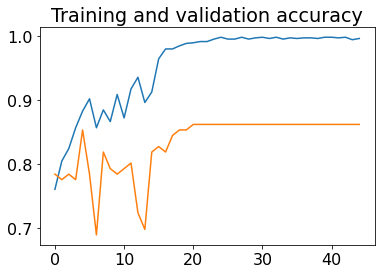

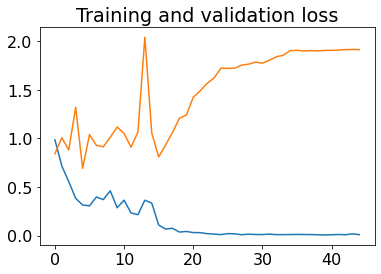

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('Training and validation accuracy')
pyplot.show()

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Training and validation loss')
pyplot.show()


In [ ]:
# test dataset

test_data_path = '/content/drive/MyDrive/2021_Zhebin_Math_Thesis/TestData40X_CTC_withoutseg_RGB'
os.listdir(test_data_path)


['Bfour', 'One', 'Three', 'Aone']

#### Test data

In [ ]:
# test dataset

test_data_path = '/content/drive/MyDrive/2021_Zhebin_Math_Thesis/TestData40X_CTC_withoutseg_RGB'
os.listdir(test_data_path)


['Bfour', 'One', 'Three', 'Aone']

In [ ]:

base_name = 'cancer'
width = 256

test_include = {'Bfour', 'One', 'Three', 'Aone'}

resize_all(src=test_data_path, pklname=base_name, width=width, include=test_include)

from collections import Counter
 
test_data = joblib.load(f'{base_name}_{width}x{width}px.pkl')

print('number of samples: ', len(test_data['data']))
print('keys: ', list(test_data.keys()))
print('description: ', test_data['description'])
print('image shape: ', test_data['data'][0].shape)
print('labels:', np.unique(test_data['label']))
 
Counter(test_data['label'])

Bfour
One
Three
Aone
number of samples:  130
keys:  ['description', 'label', 'filename', 'data']
description:  resized (256x256) cancer images in rgb
image shape:  (256, 256, 3)
labels: ['Aone' 'Bfour' 'One' 'Three']


Counter({'Aone': 12, 'Bfour': 80, 'One': 19, 'Three': 19})

In [ ]:
X_test_data = np.array(test_data['data'])
y_true_categ = np.array(test_data['label'])

print(y_true_categ)


['Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour'
 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour'
 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour'
 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour'
 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour'
 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour'
 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour'
 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour'
 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'Bfour' 'One'
 'One' 'One' 'One' 'One' 'One' 'One' 'One' 'One' 'One' 'One' 'One' 'One'
 'One' 'One' 'One' 'One' 'One' 'One' 'Three' 'Three' 'Three' 'Three'
 'Three' 'Three' 'Three' 'Three' 'Three' 'Three' 'Three' 'Three' 'Three'
 'Three' 'Three' 'Three' 'Three' 'Three' 'Three' 'Aone' 'Aone' 'Aone'
 'Aone' 'Aone' 'Aone' 'Aone' 'Aone' 'Aone' 'Aone' 'Aone' 'Ao

In [ ]:
import numpy as np

# turn string into int
def turn_int(arraylist):
  y_train_int = []
  for i in arraylist:
    if i == 'One':
      y_train_int.append(0)
    if i == 'Aone':
      y_train_int.append(1)
    if i == 'Bfour':
      y_train_int.append(2)
    if i == 'Three':
      y_train_int.append(3)
  return y_train_int

# y_true_categ_list = y_true_categ.tolist()
y_true_categ_int = turn_int(y_true_categ)
print(y_true_categ_int)


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# Define some functions for printing the results ....

labels = ['One', 'Aone','Bfour', 'Three']

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import random

from sklearn.metrics import confusion_matrix

def plot_distribution(y_true, y_pred):
    ind = np.arange(1.5,8,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color='b', alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color='r', alpha=0.3)
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 8.5])
    ax.set_ylim([0, 1000])
    ax.set_title('Test Images: True and Predicted Labels')
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,4):
        for j in range(0,4):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def plot_confusion_matrix_norm(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)

    
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 3, 3, 2, 3, 3, 1, 1, 3, 3, 3, 3, 0, 0, 3, 3, 0, 1, 1, 3, 0, 0, 1, 2, 1, 2, 1, 3, 2, 3, 2, 0, 1, 0]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 Accuracy: 
0.7846153846153846
Normalized confusion matrix
[[0.63 0.11 0.   0.26]
 [0.17 0.33 0.33 0.17]
 [0.01 0.   0.96 0.03]
 [0.26 0.21 0.05 0.47]]


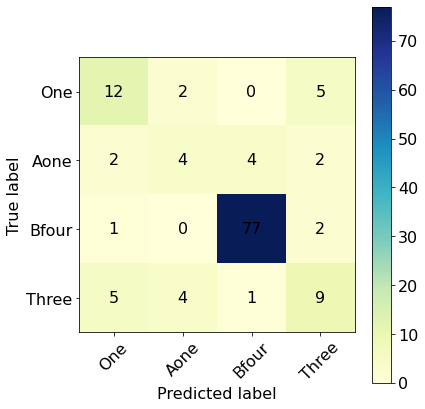

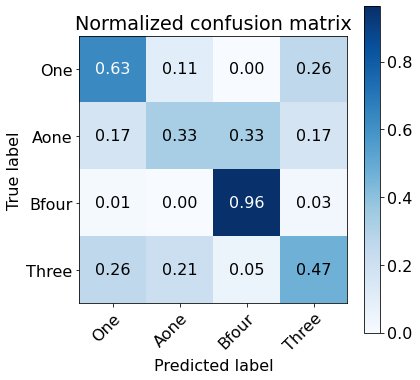

In [ ]:

# the test data is not being shuffled.
y_prob = model.predict(X_test_data, batch_size=16, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
print(y_pred)
print(y_true_categ_int)

# Get accuracy:
print("\n\n Accuracy: ")
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true_categ_int, y_pred))

# Plot the confusion matrix
plot_confusion_matrix(y_true_categ_int, y_pred, cmap=plt.cm.YlGnBu)



# Plot normalized confusion matrix

np.set_printoptions(precision=2)
plot_confusion_matrix_norm(y_true_categ_int, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
